In [43]:
from glasspy.predict.models import GlassNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.constants import pi
import numpy as np
import pandas as pd

In [25]:
myrcparams = {
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

In [26]:
def get_gs(df, jez=False):
    df['K_W_Tc'] = (df.Tc - df.Tg) / df.Tliq # best one in the paper
    df['K_W_Tx'] = (df.Tx - df.Tg) / df.Tliq
    df['gamma_Tc'] = df.Tc / (df.Tg+df.Tliq)
    df['H_prime_Tx'] = (df.Tx - df.Tg) / df.Tg
    df['K_H_Tc'] = (df.Tc - df.Tg) / (df.Tliq - df.Tc) # replaced Tmelt with Tliq
    df['H_prime_Tc'] = (df.Tc - df.Tg) / df.Tg
    df['K_H_Tx'] = (df.Tx - df.Tg) / (df.Tliq - df.Tx) # replaced Tmelt with Tliq
    df['deltaT_rg'] = (df.Tx - df.Tg) / (df.Tliq - df.Tg)
    df['K_cr'] = (df.Tliq - df.Tx) / (df.Tliq - df.Tg)
    if jez:
        df['Jezica'] = (df.ViscosityAtTl) - 2 * np.log10(df.Tliq)
    return df
    
def get_eta_tl(df):
    return df['log10 (η∞)'] + (12-df['log10 (η∞)'])*(df.T12/df.Tliq)*np.exp((df.m/(12-df['log10 (η∞)'])-1)*(df.T12/df.Tliq - 1))

def get_gfa(df, logXs = -2, logNs = 3, g=pi, **kw):
    Umax = 10 ** df.log_Umax
    
    tn = (10**logXs / (g * 10**logNs * Umax**2))**(1 / 2)

    df['GFA'] = -np.log10((df.Tliq - df.T_Umax) / tn)
    return df

In [27]:
#glassnet_test_pred_rf = pd.read_csv('glassnet_test_preds_rf.csv', index_col=0)
glassnet_test_pred_stnn = pd.read_csv('glassnet_test_preds_0_4_6_stnn.csv', index_col=0)

In [28]:
cols = ['Tg', 'Tc', 'Tx', 'Tliq', 'T_Umax', 'log_Umax']
titles = ['$T_g$', '$T_c$', '$T_x$', '$T_l$', '$T_{max(U)}$', '$log(U_{max})$']

# GlassNet dataframes

In [29]:
glassnet_no_stnn = GlassNet(st_models=[])
glassnet_stnn = GlassNet()
glassnet_test_df = pd.read_csv('glassnet_test_df.csv', index_col=0, header=[0, 1])
glassnet_train_df = pd.read_csv('glassnet_train_df.csv', index_col=0, header=[0, 1])

In [30]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [31]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)

In [32]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)

In [33]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index

In [34]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

# Compute GS and GFA

In [35]:
gs_cols = ['K_W_Tc', 'gamma_Tc', 'H_prime_Tc', 'GFA']
gs_titles = [r'$K_{W}(T_{c})$', r'$\gamma(T_{c})$', 
          r'$H^{\prime}(T_{c})$', 'GFA']

In [36]:
gs_glassnet_train = get_gs( y_glassnet_train )
gs_glassnet_test = get_gs( y_glassnet_test )
gs_glassnet_total = pd.concat( (gs_glassnet_train, gs_glassnet_test) )

In [37]:
gfa_glassnet_train = get_gfa(y_glassnet_train)
gfa_glassnet_test = get_gfa(y_glassnet_test)
gfa_glassnet_total = pd.concat( (gfa_glassnet_train, gfa_glassnet_test) )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
y_glassnet_pred_no_stnn = glassnet_test_pred_stnn[ [f'{col}_no_stnn' for col in cols] ]
y_glassnet_pred_no_stnn = y_glassnet_pred_no_stnn.rename( columns = {f'{col}_no_stnn': col for col in cols} )
gs_no_stnn = get_gs( y_glassnet_pred_no_stnn )
gfa_no_stnn = get_gfa( y_glassnet_pred_no_stnn )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
y_glassnet_pred_stnn = glassnet_test_pred_stnn[ [f'{col}_stnn' for col in cols] ]
y_glassnet_pred_stnn = y_glassnet_pred_stnn.rename( columns = {f'{col}_stnn': col for col in cols} )
gs_stnn = get_gs( y_glassnet_pred_stnn )
gfa_stnn = get_gfa( y_glassnet_pred_stnn )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
y_glassnet_pred_rf = glassnet_test_pred_rf[ [f'{col}_rf' for col in cols] ]
y_glassnet_pred_rf = y_glassnet_pred_rf.rename( columns = {f'{col}_rf': col for col in cols} )
gs_rf = get_gs( y_glassnet_pred_rf )
gfa_rf = get_gfa( y_glassnet_pred_rf )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Table 1

In [41]:
n_iter = 10

In [55]:
table_cols = ['K_W_Tc', 'K_W_Tx', 'gamma_Tc', 'H_prime_Tx', 'K_H_Tc', 'H_prime_Tc', 
              'K_H_Tx', 'deltaT_rg', 'K_cr', 'GFA']

rf_r2_df = pd.DataFrame( np.zeros( (n_iter, len(table_cols)) ) )
rf_mae_df = pd.DataFrame( np.zeros( (n_iter, len(table_cols)) ) )
rf_r2_df.columns = [f'R2_{col}' for col in table_cols]
rf_mae_df.columns = [f'MAE_{col}' for col in table_cols]

r2_arr = np.zeros( (3,len(table_cols)) )
mae_arr = np.zeros( (3,len(table_cols)) )

rf = RandomForestRegressor()
for i in range(n_iter):

    y_pred_rf = pd.read_csv(f'rf_preds_iteration{i}.csv', index_col=0)
    gs_rf = get_gs(y_pred_rf)
    gfa_rf = get_gfa(y_pred_rf)
    
    for t, col in enumerate( table_cols ):
        
        this_y_test = gs_glassnet_test[col].replace([np.inf, -np.inf], np.nan).dropna()
        this_y_rf = gs_rf.loc[this_y_test.index, col].replace([np.inf, -np.inf], np.nan).dropna()
        this_y_stnn = gs_stnn.loc[this_y_test.index, col].replace([np.inf, -np.inf], np.nan).dropna()
        this_y_no_stnn = gs_no_stnn.loc[this_y_test.index, col].replace([np.inf, -np.inf], np.nan).dropna()

        inds_rf = this_y_test.index.intersection( this_y_rf.index )
        inds_stnn = this_y_test.index.intersection( this_y_stnn.index )
        inds_no_stnn = this_y_test.index.intersection( this_y_no_stnn.index ) 

        rf_r2_df.loc[i,f'R2_{col}'] = r2_score( this_y_test.loc[inds_rf], this_y_rf.loc[inds_rf] )
        rf_mae_df.loc[i,f'MAE_{col}'] = mean_absolute_error( this_y_test.loc[inds_rf], this_y_rf.loc[inds_rf] )

        r2_arr[:,t] = [ r2_score(this_y_test.loc[inds_rf], this_y_rf.loc[inds_rf]), r2_score(this_y_test.loc[inds_stnn], this_y_stnn.loc[inds_stnn]), 
                   r2_score(this_y_test.loc[inds_no_stnn], this_y_no_stnn.loc[inds_no_stnn]) ]
        mae_arr[:,t] = [ mean_absolute_error(this_y_test.loc[inds_rf], this_y_rf.loc[inds_rf]), mean_absolute_error(this_y_test.loc[inds_stnn], this_y_stnn.loc[inds_stnn]), 
                    mean_absolute_error(this_y_test.loc[inds_no_stnn], this_y_no_stnn.loc[inds_no_stnn]) ]

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399:

In [57]:
print( rf_r2_df.mean(axis=0) )
print( rf_r2_df.std(axis=0) )

R2_K_W_Tc        0.419473
R2_K_W_Tx        0.074022
R2_gamma_Tc      0.563548
R2_H_prime_Tx    0.350113
R2_K_H_Tc        0.142664
R2_H_prime_Tc    0.594005
R2_K_H_Tx        0.046617
R2_deltaT_rg     0.305731
R2_K_cr          0.305731
R2_GFA           0.752613
dtype: float64
R2_K_W_Tc        0.026205
R2_K_W_Tx        0.042241
R2_gamma_Tc      0.011037
R2_H_prime_Tx    0.016699
R2_K_H_Tc        0.280088
R2_H_prime_Tc    0.003950
R2_K_H_Tx        0.051481
R2_deltaT_rg     0.030866
R2_K_cr          0.030866
R2_GFA           0.035258
dtype: float64


In [58]:
print( rf_mae_df.mean(axis=0) )
print( rf_mae_df.std(axis=0) )

MAE_K_W_Tc        0.033737
MAE_K_W_Tx        0.033850
MAE_gamma_Tc      0.023036
MAE_H_prime_Tx    0.047638
MAE_K_H_Tc        0.527883
MAE_H_prime_Tc    0.051766
MAE_K_H_Tx        0.325528
MAE_deltaT_rg     0.103598
MAE_K_cr          0.103598
MAE_GFA           0.626390
dtype: float64
MAE_K_W_Tc        0.000484
MAE_K_W_Tx        0.000359
MAE_gamma_Tc      0.000253
MAE_H_prime_Tx    0.000339
MAE_K_H_Tc        0.034263
MAE_H_prime_Tc    0.000282
MAE_K_H_Tx        0.006444
MAE_deltaT_rg     0.001192
MAE_K_cr          0.001192
MAE_GFA           0.045661
dtype: float64


In [47]:
r2_df = pd.DataFrame(r2_arr)
r2_df.columns = [table_cols]
r2_df.index = ['RF', 'STNN', 'No STNN']

mae_df = pd.DataFrame(mae_arr)
mae_df.columns = [table_cols]
mae_df.index = ['RF', 'STNN', 'No STNN']

In [48]:
mae_df

,K_W_Tc,K_W_Tx,gamma_Tc,H_prime_Tx,K_H_Tc,H_prime_Tc,K_H_Tx,deltaT_rg,K_cr,GFA
RF,0.034546,0.034315,0.023871,0.047545,0.523969,0.052133,0.352959,0.105927,0.105927,0.616505
STNN,0.035701,0.034636,0.023505,0.062177,0.579048,0.063105,0.312795,0.105739,0.105739,0.678111
No STNN,0.040898,0.034136,0.029593,0.057778,0.579167,0.074009,0.340627,0.114086,0.114086,0.748156


In [49]:
r2_df

,K_W_Tc,K_W_Tx,gamma_Tc,H_prime_Tx,K_H_Tc,H_prime_Tc,K_H_Tx,deltaT_rg,K_cr,GFA
RF,0.376713,-0.026397,0.526657,0.347565,0.203087,0.595604,-0.174079,0.223839,0.223839,0.783603
STNN,0.439903,0.111550,0.632917,0.196489,0.180157,0.445203,0.067903,0.260491,0.260491,0.682594
No STNN,0.307295,0.165191,0.414759,0.215062,0.324201,0.280190,0.052093,0.241739,0.241739,0.657357


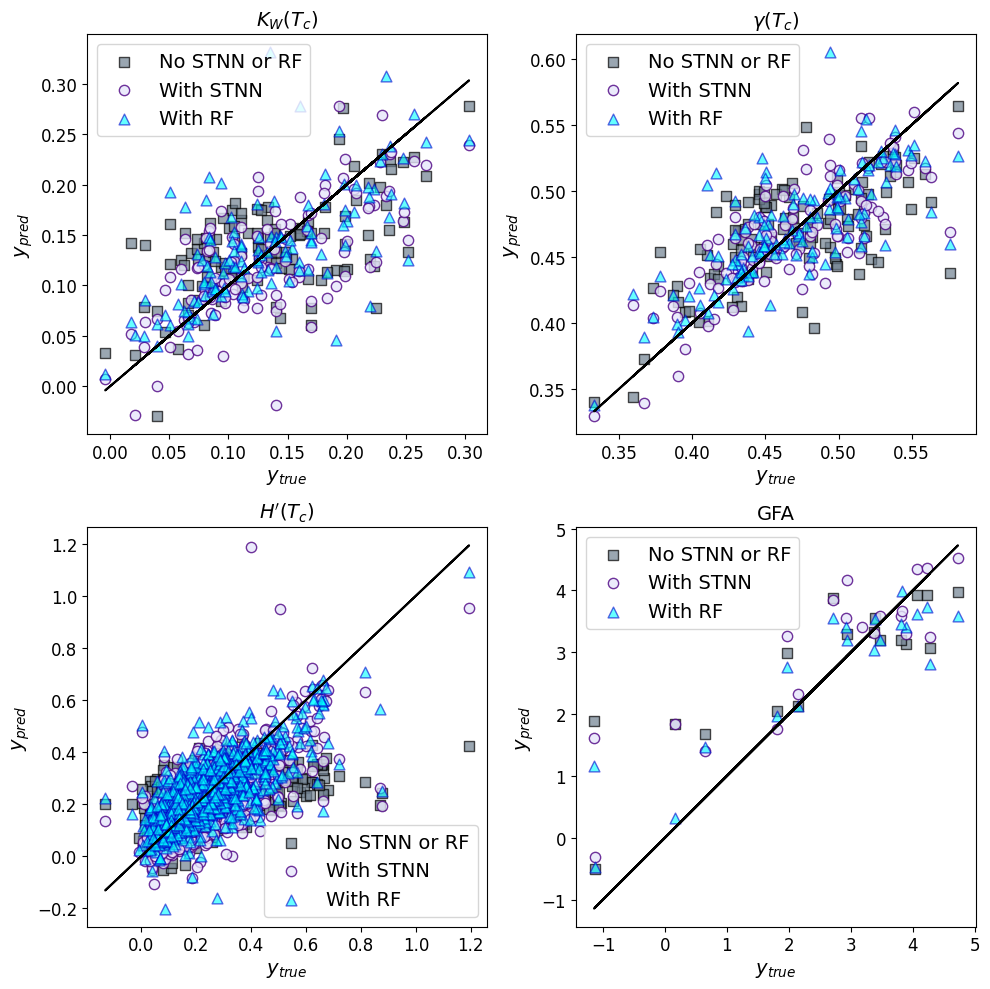

In [59]:
r2_arr = np.zeros( (3,len(gs_cols)) )
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
for i,col in enumerate(gs_cols):
    y_true = gs_glassnet_test[col]
    y_rf = gs_rf[col]
    y_stnn = gs_stnn[col]
    y_no_stnn = gs_no_stnn[col]
    
    y_true_nona = y_true.replace([np.inf, -np.inf], np.nan).dropna()
    y_rf_nona = y_rf[ y_true_nona.index ].replace([np.inf, -np.inf], np.nan).dropna()
    y_stnn_nona = y_stnn[ y_true_nona.index ].replace([np.inf, -np.inf], np.nan).dropna()
    y_no_stnn_nona = y_no_stnn[ y_true_nona.index ].replace([np.inf, -np.inf], np.nan).dropna()

    inds_rf = y_true_nona.index.intersection( y_rf_nona.index )
    inds_stnn = y_true_nona.index.intersection( y_stnn_nona.index )
    inds_no_stnn = y_true_nona.index.intersection( y_no_stnn_nona.index )
    
    r2_arr[:,i] = [ r2_score(y_true_nona.loc[inds_rf], y_rf_nona.loc[inds_rf]), r2_score(y_true_nona.loc[inds_stnn], y_stnn_nona.loc[inds_stnn]), r2_score(y_true_nona.loc[inds_no_stnn], y_no_stnn_nona.loc[inds_no_stnn]) ]
  
    if i < 2:
        ax = axes[0,i]
    else:
        ax = axes[1,i-2]
        
    ax.plot(y_true_nona, y_true_nona, color='black',linewidth=1.5)
    ax.scatter(y_true_nona.loc[inds_no_stnn], y_no_stnn_nona.loc[inds_no_stnn], marker='s', s=50, alpha=0.7, color='slategrey', edgecolor='black', label='No STNN or RF')
    ax.scatter(y_true_nona.loc[inds_stnn], y_stnn_nona.loc[inds_stnn], marker='o', s=55, alpha=0.8, color='lavender', edgecolor='indigo', label='With STNN')
    ax.scatter(y_true_nona.loc[inds_rf], y_rf_nona.loc[inds_rf], marker='^', s=60, alpha=0.6, color='cyan', edgecolor='mediumblue', label='With RF')
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$y_{pred}$')
    ax.set_title(gs_titles[i])
    ax.legend()
    
fig.savefig(f'figure2.png', dpi=600)

In [30]:
r2_df = pd.DataFrame(r2_arr)
r2_df.columns = [gs_cols]
r2_df.index = ['RF', 'STNN', 'No STNN']

In [31]:
r2_df

,K_W_Tc,gamma_Tc,H_prime_Tc,GFA
RF,0.401828,0.543769,0.582524,0.718182
STNN,0.439903,0.632917,0.445203,0.682594
No STNN,0.307295,0.414759,0.280190,0.657357
